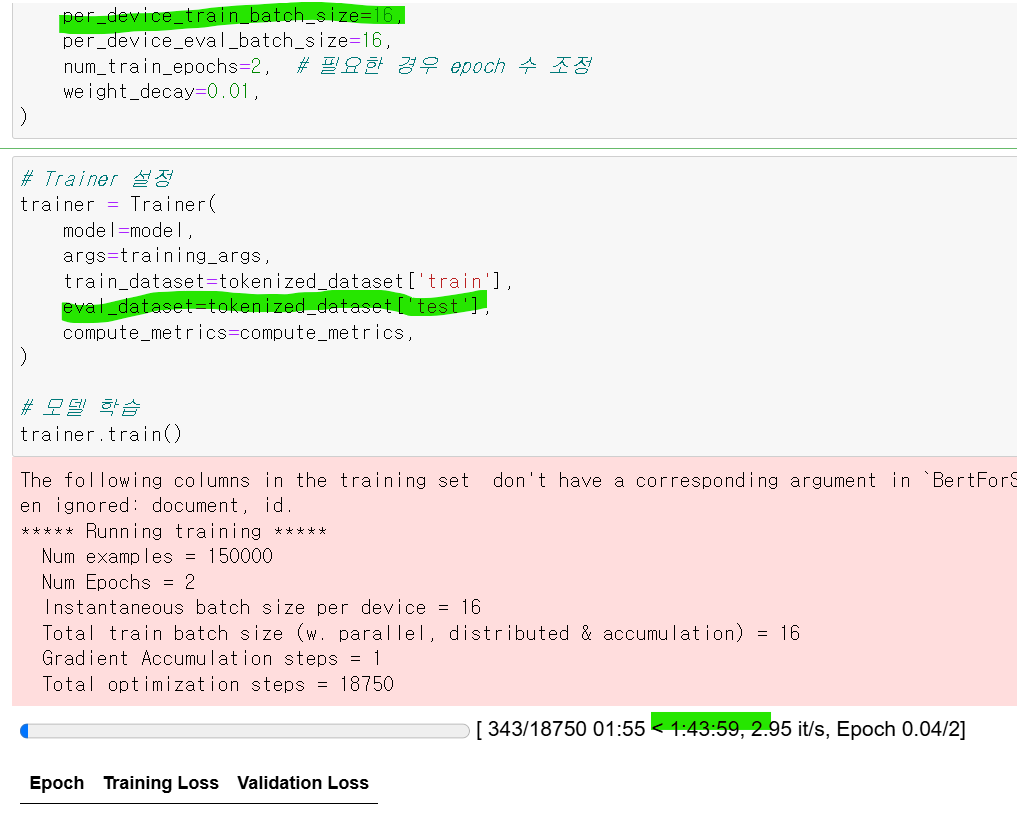
- 배치를 16으로 해도 돌아가고 
- 15만개를 진행해도 2에폭에 1시간 50분..!

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import transformers 
import datasets


from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification

In [2]:
dataset = load_dataset('nsmc')
dataset

Downloading:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/807 [00:00<?, ?B/s]

Using custom data configuration default


  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/6.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset nsmc downloaded and prepared to /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})

In [3]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2)

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

In [4]:
# 데이터 전처리 함수 정의
def preprocess(data):
    return tokenizer(data['document'], truncation=True, padding="max_length", max_length=128)

# 전처리된 데이터셋 생성
tokenized_dataset = dataset.map(preprocess, batched=True)

# 학습 및 평가에 필요한 데이터셋 형식으로 변환
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")  # 'label'을 'labels'로 변경
tokenized_dataset.set_format("torch")  # PyTorch 텐서 형식으로 설정

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [5]:
# 모델 성능 평가를 위한 정확도 계산 함수
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

In [6]:
# TrainingArguments 설정

training_args = TrainingArguments(
    output_dir = os.getenv('HOME')+'/aiffel/transformers',
    evaluation_strategy="epoch",
    learning_rate=2e-5,  # 학습률 조정
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,  # 필요한 경우 epoch 수 조정
    weight_decay=0.01,
)

In [7]:
# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    compute_metrics=compute_metrics,
)

# 모델 학습
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: document, id.
***** Running training *****
  Num examples = 150000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 18750


Epoch,Training Loss,Validation Loss


Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1000
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/transformers/checkpoint-1500
Configuration saved in /aiffel/aiffel/transformers/checkpoint-1500/config.json
Model weights saved in /aiffel/aiffel/transformers/checkpoint-1500/pytorch_model.bin


KeyboardInterrupt: 